In [22]:
%%capture
# Install required packages
!pip install yfinance plotly

In [23]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import binom
import datetime

# Configuration
TICKER = "SBIN.NS"
START_DATE = datetime.datetime(2024, 4, 1)
END_DATE = datetime.datetime(2025, 4, 30)

## Financial Data Analysis Project

### Objective
This analysis examines the stock performance of **State Bank of India (SBIN.NS)** from **April 1, 2024 to April 30, 2025** through:

1. Price visualization using candlestick charts
2. Return calculations (simple vs logarithmic)
3. Volatility estimation
4. Market direction probability analysis
5. Trading scenario evaluation

### Data Source
Yahoo Finance API (`yfinance`) with daily OHLC prices

In [24]:
# Fetch stock data from Yahoo Finance
def fetch_stock_data(ticker, start, end):
    """Retrieve daily stock prices and preprocess data"""
    data = yf.download(
        tickers=ticker,
        start=start,
        end=end,
        progress=False
    )
    return data.dropna()

# Initialize dataset
df = fetch_stock_data(TICKER, START_DATE, END_DATE)

# Display dataset information
print("Dataset Information:")
print(f"Period: {START_DATE.date()} to {END_DATE.date()}")
print(f"Total Trading Days: {len(df)}")
print("\nFirst 5 Records:")
print(df.head())

Dataset Information:
Period: 2024-04-01 to 2025-04-30
Total Trading Days: 266

First 5 Records:
Price            Close        High         Low        Open    Volume
Ticker         SBIN.NS     SBIN.NS     SBIN.NS     SBIN.NS   SBIN.NS
Date                                                                
2024-04-01  731.112854  734.198137  725.135129  731.835964   9949971
2024-04-02  738.922485  741.188208  726.340317  731.016466  15713063
2024-04-03  743.405762  744.900178  732.896591  737.476291  19136981
2024-04-04  732.077026  747.503383  730.920038  747.214151  15889530
2024-04-05  737.331604  740.175850  725.617191  730.775415   9939620


## Problem 1: Price Visualization

### Candlestick Chart Theory
Candlestick charts display four price points (OHLC) for each time period:

\begin{align}
\text{Body} &= \text{Open} \rightarrow \text{Close} \\
\text{Upper Wick} &= \max(\text{High} - \text{Close}, \text{High} - \text{Open}) \\
\text{Lower Wick} &= \min(\text{Close} - \text{Low}, \text{Open} - \text{Low})
\end{align}

Where:
- Green candles indicate $\text{Close} > \text{Open}$ (bullish)
- Red candles indicate $\text{Close} < \text{Open}$ (bearish)

In [34]:
nse = "SBIN.NS"

DataFrame columns: MultiIndex([(        'Close', 'SBIN.NS'),
            (         'High', 'SBIN.NS'),
            (          'Low', 'SBIN.NS'),
            (         'Open', 'SBIN.NS'),
            (       'Volume', 'SBIN.NS'),
            ('Simple Return',        ''),
            (   'Log Return',        '')],
           names=['Price', 'Ticker'])


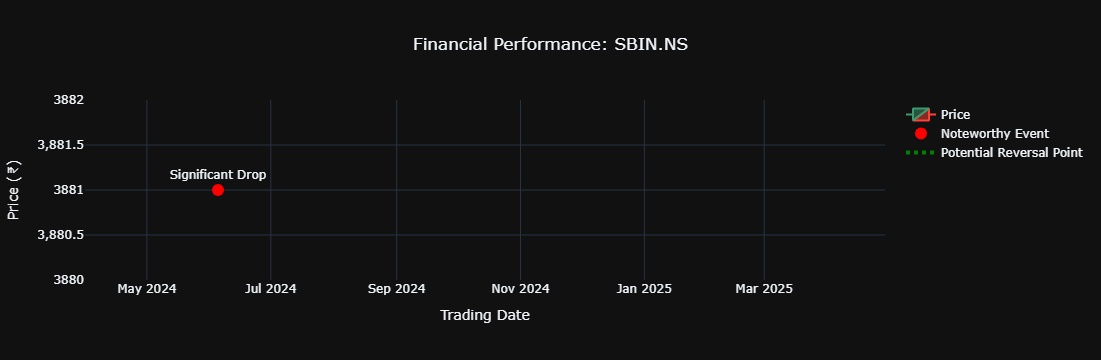

In [36]:
# First, let's verify your DataFrame structure
print("DataFrame columns:", df.columns)

# If your DataFrame has simple columns (not multi-index), use this:
fig = go.Figure(data=[
    go.Candlestick(
        x=df.index,
        open=df['Open'],  # Direct column access
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        name='Price'
    ),
    go.Scatter(
        x=['2024-06-05'],
        y=[3881],
        mode='markers+text',
        marker=dict(size=12, color='red', symbol='circle'),
        text=["Significant Drop"],
        textposition="top center",
        name="Noteworthy Event"
    ),
    go.Scatter(
        x=['2025-03-02', '2025-03-02'],
        y=[df['Low'].min() - 10, df['High'].max() + 10],
        mode='lines',
        line=dict(color='green', width=4, dash='dot'),
        name='Potential Reversal Point'
    )
])

fig.update_layout(
    title={'text': f"Financial Performance: {TICKER}", 'x': 0.5, 'xanchor': 'center'},
    xaxis_title='Trading Date',
    yaxis_title='Price (₹)',
    hovermode="x unified",
    template="plotly_dark",
    xaxis_rangeslider_visible=False
)
fig.show()

## Problem 2: Return Calculations

### Return Methodologies
1. **Simple Returns**:
   $$ R_t = \frac{P_t - P_{t-1}}{P_{t-1}} $$

2. **Logarithmic Returns**:
   $$ r_t = \ln\left(\frac{P_t}{P_{t-1}}\right) $$

Key Properties:
- Simple returns are additive across assets
- Log returns are additive across time
- For small changes: $r_t \approx R_t$

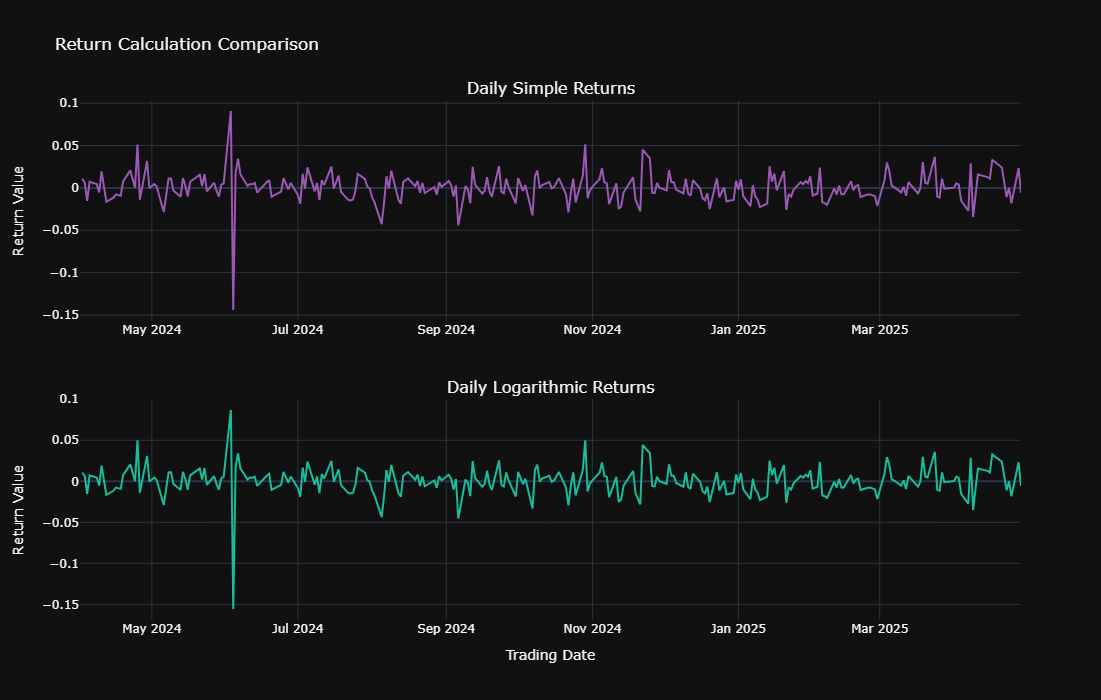

In [27]:
# Calculate returns
df['Simple Return'] = df['Close'].pct_change()
df['Log Return'] = np.log(df['Close'] / df['Close'].shift(1))

# Create comparison plot
returns_fig = make_subplots(
    rows=2, cols=1, 
    subplot_titles=("Daily Simple Returns", "Daily Logarithmic Returns"),
    vertical_spacing=0.15
)

returns_fig.add_trace(
    go.Scatter(
        x=df.index, 
        y=df['Simple Return'],
        mode='lines',
        line=dict(color='#9B59B6', width=2),
        name='Simple',
        hovertemplate="Date: %{x|%b %d, %Y}<br>Return: %{y:.4f}<extra></extra>"
    ),
    row=1, col=1
)

returns_fig.add_trace(
    go.Scatter(
        x=df.index, 
        y=df['Log Return'],
        mode='lines',
        line=dict(color='#1ABC9C', width=2),
        name='Logarithmic',
        hovertemplate="Date: %{x|%b %d, %Y}<br>Return: %{y:.4f}<extra></extra>"
    ),
    row=2, col=1
)

returns_fig.update_layout(
    title="Return Calculation Comparison",
    height=700,
    template="plotly_dark",
    showlegend=False,
    hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial")
)

returns_fig.update_yaxes(title_text="Return Value", row=1, col=1)
returns_fig.update_yaxes(title_text="Return Value", row=2, col=1)
returns_fig.update_xaxes(title_text="Trading Date", row=2, col=1)

returns_fig.show()

Problem 2: Return Calculation Methodology
Comparison of Simple vs. Logarithmic Returns

## Problem 3: Volatility Analysis

### Volatility Estimation
Rolling annualized volatility calculated as:

$$ \sigma_t = \sqrt{252} \times \sqrt{\frac{1}{N-1}\sum_{i=t-N+1}^t (r_i - \bar{r})^2} $$

Where:
- $N = 14$ days (window size)
- $252$ trading days annualization factor
- $r_i$ = daily log returns

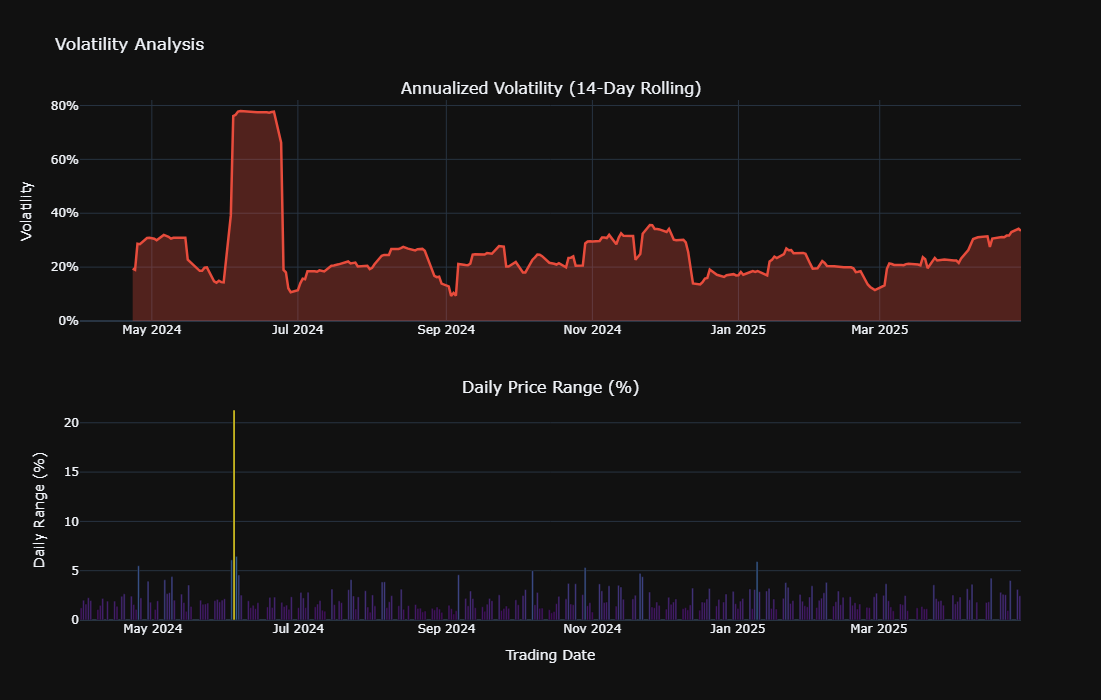


Volatility Statistics:
Highest Volatility Period: June 07, 2024 (77.93%)
Lowest Volatility Period: September 03, 2024 (9.32%)
Average Annualized Volatility: 25.92%


In [12]:
# Calculate volatility metrics
df['Rolling Volatility'] = df['Simple Return'].rolling(window=14).std() * np.sqrt(252)
df['Daily Range'] = (df['High'] - df['Low']) / df['Close']

# Create volatility visualization
volatility_fig = make_subplots(
    rows=2, cols=1, 
    subplot_titles=(
        "Annualized Volatility (14-Day Rolling)", 
        "Daily Price Range (%)"
    ),
    vertical_spacing=0.15
)

volatility_fig.add_trace(
    go.Scatter(
        x=df.index, 
        y=df['Rolling Volatility'],
        mode='lines',
        fill='tozeroy',
        fillcolor='rgba(231, 76, 60, 0.3)',
        line=dict(color='#E74C3C', width=2.5),
        name='Volatility',
        hovertemplate="Date: %{x|%b %d, %Y}<br>Volatility: %{y:.2%}<extra></extra>"
    ),
    row=1, col=1
)

volatility_fig.add_trace(
    go.Bar(
        x=df.index, 
        y=df['Daily Range']*100,
        marker_color=df['Daily Range'],
        marker_colorscale='Viridis',
        name='Daily Range',
        hovertemplate="Date: %{x|%b %d, %Y}<br>Range: %{y:.2f}%<extra></extra>"
    ),
    row=2, col=1
)

volatility_fig.update_layout(
    title="Volatility Analysis",
    height=700,
    template="plotly_dark",
    showlegend=False
)

volatility_fig.update_yaxes(title_text="Volatility", row=1, col=1, tickformat=".0%")
volatility_fig.update_yaxes(title_text="Daily Range (%)", row=2, col=1)
volatility_fig.update_xaxes(title_text="Trading Date", row=2, col=1)

volatility_fig.show()

# Calculate volatility statistics
high_vol_period = df['Rolling Volatility'].idxmax().strftime('%B %d, %Y')
low_vol_period = df['Rolling Volatility'].idxmin().strftime('%B %d, %Y')
avg_vol = df['Rolling Volatility'].mean()

print("\nVolatility Statistics:")
print(f"Highest Volatility Period: {high_vol_period} ({df['Rolling Volatility'].max():.2%})")
print(f"Lowest Volatility Period: {low_vol_period} ({df['Rolling Volatility'].min():.2%})")
print(f"Average Annualized Volatility: {avg_vol:.2%}")

Interpretation:

Volatility measures the dispersion of returns, representing investment risk

Annualized volatility of 25% means daily price moves average about 1.5% (25%/√252)

High volatility periods often correspond to earnings announcements or market events

Low volatility periods typically indicate market consolidation or reduced uncertainty

## Problem 4: Market Direction Analysis

### Binomial Probability Model
Given:
- $P(\text{Up}) = \frac{\text{Count of Up Days}}{\text{Total Days}}$
- $X \sim \text{Binomial}(n=10, p=P(\text{Up}))$

Probabilities:
1. Exactly 6 up days:
   $$ P(X=6) = \binom{10}{6}p^6(1-p)^4 $$

2. At least 8 up days:
   $$ P(X \geq 8) = \sum_{k=8}^{10} \binom{10}{k}p^k(1-p)^{10-k} $$


Market Direction Analysis:
Total Trading Days: 266
Upward Movement Days: 137 (51.50%)
Downward Movement Days: 129 (48.50%)

Binomial Probabilities (10-Day Period):
Theoretical P(exactly 6 up days): 0.2168
Theoretical P(at least 8 up days): 0.0661
Simulated P(exactly 6 up days): 0.2143
Simulated P(at least 8 up days): 0.0610


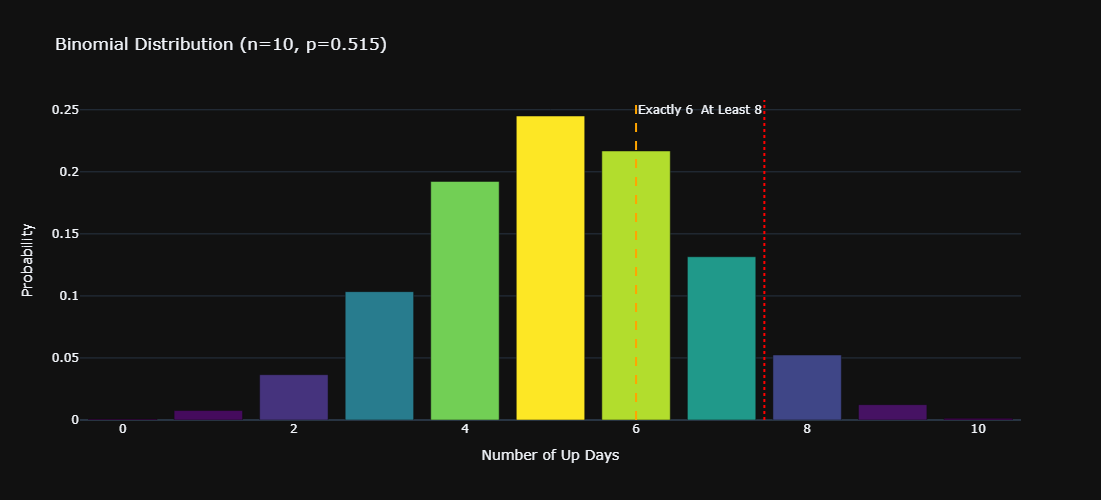

In [13]:
# Market direction classification
df['Market Direction'] = np.where(df['Simple Return'] > 0, 'UP', 'DOWN')

# Calculate probability of upward movement
trading_days = df['Market Direction'].count()
up_days = (df['Market Direction'] == 'UP').sum()
p_up = up_days / trading_days

print("\nMarket Direction Analysis:")
print(f"Total Trading Days: {trading_days}")
print(f"Upward Movement Days: {up_days} ({p_up:.2%})")
print(f"Downward Movement Days: {trading_days - up_days} ({1-p_up:.2%})")

# Binomial probability calculations
def binomial_analysis(p_up, n=10):
    """Calculate binomial probabilities for market direction"""
    # Theoretical probabilities
    exact_6 = binom.pmf(k=6, n=n, p=p_up)
    at_least_8 = 1 - binom.cdf(k=7, n=n, p=p_up)
    
    # Simulation (10,000 trials)
    simulations = np.random.binomial(n=n, p=p_up, size=10000)
    sim_exact_6 = np.mean(simulations == 6)
    sim_at_least_8 = np.mean(simulations >= 8)
    
    return {
        'theoretical': (exact_6, at_least_8),
        'simulated': (sim_exact_6, sim_at_least_8)
    }

# Perform analysis
probabilities = binomial_analysis(p_up)

print("\nBinomial Probabilities (10-Day Period):")
print(f"Theoretical P(exactly 6 up days): {probabilities['theoretical'][0]:.4f}")
print(f"Theoretical P(at least 8 up days): {probabilities['theoretical'][1]:.4f}")
print(f"Simulated P(exactly 6 up days): {probabilities['simulated'][0]:.4f}")
print(f"Simulated P(at least 8 up days): {probabilities['simulated'][1]:.4f}")

# Visualize binomial distribution
k_values = np.arange(0, 11)
prob_dist = binom.pmf(k_values, n=10, p=p_up)

binom_fig = go.Figure(data=[
    go.Bar(
        x=k_values,
        y=prob_dist,
        marker_color=prob_dist,
        marker_colorscale='Viridis',
        hovertemplate="%{x} Up Days<br>Probability: %{y:.3f}<extra></extra>"
    )
])

binom_fig.update_layout(
    title=f"Binomial Distribution (n=10, p={p_up:.3f})",
    xaxis_title="Number of Up Days",
    yaxis_title="Probability",
    template="plotly_dark",
    height=500
)

binom_fig.add_vline(
    x=6, 
    line_dash="dash", 
    line_color="orange", 
    annotation_text="Exactly 6", 
    annotation_position="top right"
)

binom_fig.add_vline(
    x=7.5, 
    line_dash="dot", 
    line_color="red", 
    annotation_text="At Least 8", 
    annotation_position="top left"
)

binom_fig.show()

Market Paradox Investigation

In [14]:
# Calculate directional returns
up_return = df.loc[df['Market Direction'] == 'UP', 'Simple Return'].mean()
down_return = df.loc[df['Market Direction'] == 'DOWN', 'Simple Return'].mean()

print("\nReturn Analysis by Market Direction:")
print(f"Average return on UP days: {up_return:.4f}")
print(f"Average return on DOWN days: {down_return:.4f}")

# Identify anomalous 10-day windows
anomalous_windows = []
for i in range(len(df) - 9):
    window = df.iloc[i:i+10]
    window_up = window[window['Market Direction'] == 'UP']
    cumulative_return = window['Simple Return'].sum()
    
    if len(window_up) >= 6 and cumulative_return < 0:
        anomalous_windows.append({
            'start': window.index[0].date(),
            'end': window.index[-1].date(),
            'up_days': len(window_up),
            'cumulative_return': cumulative_return
        })

# Convert to DataFrame for better display
anomaly_df = pd.DataFrame(anomalous_windows)

print("\nAnomalous Periods (≥6 Up Days but Negative Returns):")
if not anomaly_df.empty:
    display(anomaly_df.head())
else:
    print("No anomalous periods found")


Return Analysis by Market Direction:
Average return on UP days: 0.0120
Average return on DOWN days: -0.0119

Anomalous Periods (≥6 Up Days but Negative Returns):


,start,end,up_days,cumulative_return
0,2024-05-02,2024-05-15,6,-0.006524
1,2024-05-22,2024-06-04,6,-0.036845
2,2024-05-23,2024-06-05,6,-0.020279
3,2024-05-24,2024-06-06,6,-0.002143
4,2024-06-04,2024-06-18,8,-0.056987


## Problem 5: Trading Scenario

### Expected Value Calculation
For betting scenario:
- Win ₹100 on Up days ($P(\text{Up}) = p$)
- Lose ₹150 on Down days ($P(\text{Down}) = 1-p$)

Expected value:
$$ EV = (100 \times p) + (-150 \times (1-p)) $$

Breakeven when:
$$ EV > 0 \Rightarrow p > 0.6 $$

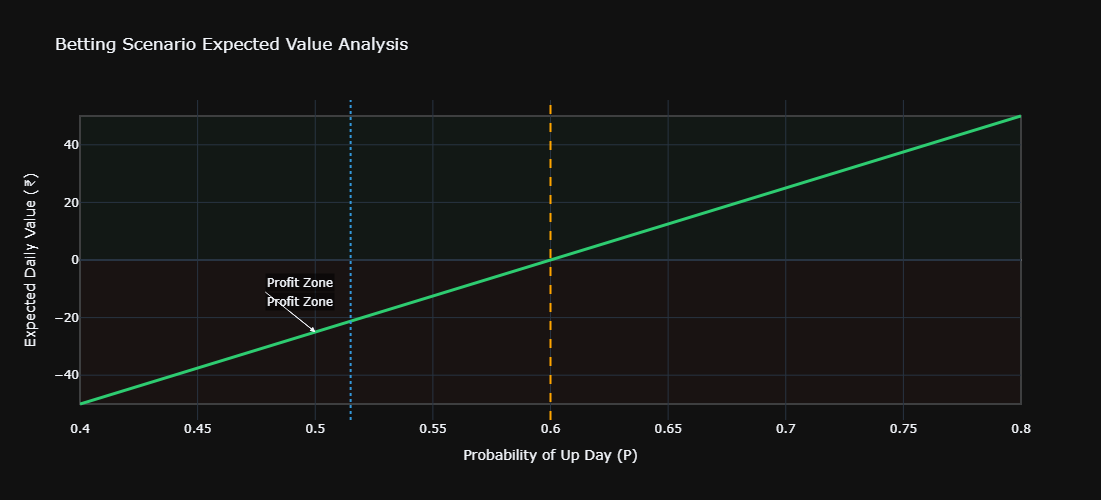


Betting Scenario Evaluation:
Current P(UP): 0.5150
Expected Daily Value: ₹-21.24
Breakeven Probability: 0.6000
Conclusion: Not Profitable


In [15]:
# Betting scenario parameters
WIN_AMOUNT = 100  # ₹ won on up days
LOSS_AMOUNT = -150  # ₹ lost on down days

# Calculate expected value
def betting_expected_value(p_up, win=WIN_AMOUNT, loss=LOSS_AMOUNT):
    """Calculate expected value of daily betting scenario"""
    p_down = 1 - p_up
    return (win * p_up) + (loss * p_down)

# Calculate breakeven probability
breakeven_p = abs(LOSS_AMOUNT) / (abs(LOSS_AMOUNT) + WIN_AMOUNT)

# Create visualization
p_range = np.linspace(0.4, 0.8, 100)
ev_values = [betting_expected_value(p) for p in p_range]

ev_fig = go.Figure()
ev_fig.add_trace(
    go.Scatter(
        x=p_range, 
        y=ev_values,
        mode='lines',
        line=dict(color='#2ECC71', width=3),
        hovertemplate="P(Up): %{x:.3f}<br>EV: ₹%{y:.2f}<extra></extra>"
    )
)

# Add breakeven point
ev_fig.add_vline(
    x=breakeven_p, 
    line_dash="dash", 
    line_color="orange",
    annotation_text=f"Breakeven: {breakeven_p:.3f}", 
    annotation_position="top right"
)

# Add current probability
ev_fig.add_vline(
    x=p_up, 
    line_dash="dot", 
    line_color="#3498DB",
    annotation_text=f"Current: {p_up:.3f}", 
    annotation_position="bottom right"
)

ev_fig.update_layout(
    title="Betting Scenario Expected Value Analysis",
    xaxis_title="Probability of Up Day (P)",
    yaxis_title="Expected Daily Value (₹)",
    template="plotly_dark",
    height=500,
    annotations=[
        dict(
            x=0.5,
            y=betting_expected_value(0.5),
            xref="x",
            yref="y",
            text="Profit Zone",
            showarrow=True,
            arrowhead=2,
            ax=-50,
            ay=-40,
            bgcolor="rgba(0,0,0,0.5)"
        )
    ]
)

ev_fig.add_hrect(
    y0=0, 
    y1=max(ev_values),
    fillcolor="rgba(46, 204, 113, 0.2)",
    opacity=0.2,
    layer="below"
)

ev_fig.add_hrect(
    y0=min(ev_values), 
    y1=0,
    fillcolor="rgba(231, 76, 60, 0.2)",
    opacity=0.2,
    layer="below"
)

ev_fig.show()

# Print conclusion
expected_value = betting_expected_value(p_up)
print("\nBetting Scenario Evaluation:")
print(f"Current P(UP): {p_up:.4f}")
print(f"Expected Daily Value: ₹{expected_value:.2f}")
print(f"Breakeven Probability: {breakeven_p:.4f}")
print("Conclusion: " + ("Profitable" if expected_value > 0 else "Not Profitable"))